# Practica de Cas Kaggle

## Entenent La Base De Dades

Ens trobem amb una base de dades de Pokemon. Cal considerar, per aquesta practica el seguent:
* Els Pokemon tenen diferents habilitats en funció del tipus de pokemon que siguin (pokemons tipus Normal, Aigua, Foc, Electric, Gel, ...)
* En total hi han 18 tipus de pokemon.

Tot i que no apareix a la BD, cal entendre que:

* Cada Pokemon te una quantitat de punts de vida HP (Health Points)
* Cada Pokemon te una serie de atacs especials, amb una quantitat X de dany determinada per a cada atac, que fa disminuir en X el HP del pokemon atacat.

Tenim en compte que:

* El tipus que sigui un pokemon influeix en la efectivitat dels seus atacs contra altres tipus de pokemon. Per exemple, els pokemon de tipus foc (com per exemple Flareon) son més debils contra pokemons de tipus aigua (com per exemple Vaporeon) pero no més debils que els pokemons de tipus electric (Com per exemple Jolteon). Per exemple, suposant que Flareon i Vaporeon tinguessin els mateixos HP, podriem assegurar que Vaporeon guanyaria a Flareon.

Per tant podem dir que:

* L'efectivitat dels atacs ve determinada, llavors, per un multiplicador sobre el dany del atac, que depen tant del tipus de pokemon del atacant com del tipus de pokemon del atacat.

La base de dades te la següent informació per a cada fila:
   * 1. Un atribut amb el nom del Pokemon
   * 2. Un atribut amb el numero del Pokemon dins de la Pokedex (Llista de pokemons) -> Equivalent a un ID
   * 3. Atributs que representen multiplicadors de dany que el pokemon en questió pot influir sobre altres tipus de pokemon --> un per cada tipus de pokemon rival

Provem llavors a mirar el tamany de la BD:


In [417]:
# IMPORTS
import math
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# IMPORTS LINEAR REGRESSION
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from mpl_toolkits.mplot3d import axes3d, Axes3D

# IMPORTS DATA CLASSIFICATION:
#from sklearn.linear_model import LogisticRegression
#from sklearn import svm, datasets
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc


# llegim el dataset
pokemon_dataset = pd.read_csv('PokeTypeMatchupData.csv', header=0, delimiter=',')
pokemon_data = pokemon_dataset.values

x = pokemon_data[:, :2]
y = pokemon_data[:, 2]

print("Dimensionalitat de la BBDD:", pokemon_dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

n_tipus = 18


Dimensionalitat de la BBDD: (576, 20)
Dimensionalitat de les entrades X (576, 2)
Dimensionalitat de l'atribut Y (576,)


Com podem veure, La base de dades té 20 atributs i 576 files. 

A continuació es mostra les 5 primeres files com a exemple del contingut:

In [418]:
pokemon_dataset.head()

,Name,Number,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Bulbasaur,#001,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
1,Ivysaur,#002,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
2,Venusaur,#003,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
3,Charmander,#004,*1,*0.5,*2,*1,*0.5,*0.5,*1,*1,*2,*1,*1,*0.5,*2,*1,*1,*1,*0.5,*0.5
4,Charmeleon,#005,*1,*0.5,*2,*1,*0.5,*0.5,*1,*1,*2,*1,*1,*0.5,*2,*1,*1,*1,*0.5,*0.5


# Objectius

Per a un entrenador Pokemon, podria ser interessant resoldre alguna de les seguents preguntes:

- Donat un pokemon saber per a quins rivals son més forts, més debils o igualats en forçes --> NO
- Quins tipus de pokemon son mes forts/debils respecte als altres? --> NO

Aquestes preguntes, pero, tot i semblar ser utils, no es necessari aplicar cap metode de machine learning per a trobar la solucio. Per tant, val més buscar-ne una pregunta més complexa que pugui també resultar ser util, com per exemple la seguent:
- **Quin equip de Pokemons podem escollir per minimitzar les debilitats i maximitzar les forçes?** --> SI

Aquesta pregunta si que podem resoldrela aplicant conceptes de la assignatura, en aquest cas, seria interessant utilitzar clustering per adivinar quins son els grups de tipus de pokemon que fossin la combinació més forta o més debil.


# Preparant les dades

Com hem vist en la comanda head(), les dades es troben amb un format
que no ens interessa per a les seguents fases, ja que el ID te un simbol (#) abans del numero, i els multiplicadors venen precedits per el simbol (*):

In [419]:
print(pokemon_dataset.values)

[['Bulbasaur' '#001' '*1' ... '*1' '*1' '*0.5']
 ['Ivysaur' '#002' '*1' ... '*1' '*1' '*0.5']
 ['Venusaur' '#003' '*1' ... '*1' '*1' '*0.5']
 ...
 ['Urshifu' '#892' '*1' ... '*0.25' '*1' '*4']
 ['Urshifu Rapid Strike' '#892' '*1' ... '*0.5' '*0.5' '*2']
 ['Zarude' '#893' '*1' ... '*0.5' '*1' '*2']]


Per tant, ens interessa desfer-nos d'aquests simbols.

In [420]:
for fila in pokemon_data:
    fila[1] = fila[1].replace("#", "")
    for i in range(2, 20):
        fila[i] = fila[i].replace("*", "")
print(pokemon_data)

[['Bulbasaur' '001' '1' ... '1' '1' '0.5']
 ['Ivysaur' '002' '1' ... '1' '1' '0.5']
 ['Venusaur' '003' '1' ... '1' '1' '0.5']
 ...
 ['Urshifu' '892' '1' ... '0.25' '1' '4']
 ['Urshifu Rapid Strike' '892' '1' ... '0.5' '0.5' '2']
 ['Zarude' '893' '1' ... '0.5' '1' '2']]


**Un cop Netejades les dades, cal mirar si hi ha alguns valors NaN o no:**

In [421]:
print(pokemon_dataset.isnull().sum())
print("\nNumero de files NaN:", pokemon_dataset.isna().sum().sum())

Name        0
Number      0
Normal      0
Fire        0
Water       0
Electric    0
Grass       0
Ice         0
Fighting    0
Poison      0
Ground      0
Flying      0
Psychic     0
Bug         0
Rock        0
Ghost       0
Dragon      0
Dark        0
Steel       0
Fairy       0
dtype: int64

Numero de files NaN: 0


Veiem que no hi ha cap valor NaN o Null. 

**Busquem també per files repetides, o si hi ha pokemons diferents que comparteixin el mateix ID:**

In [422]:
duplicateRows = pokemon_dataset[pokemon_dataset.duplicated()]
print("=================================================================================\n")
print("Numero total de Files duplicades: ",len(duplicateRows))
duplicateRows = pokemon_dataset[pokemon_dataset['Number'].duplicated()]
print("Files que tenen un ID que es repeteixi en altres files: ", len(duplicateRows),  "\n")
print("=================================================================================")


Numero total de Files duplicades:  0
Files que tenen un ID que es repeteixi en altres files:  36 



Com veiem, tenim 36 files on s'utilitza un ID repetit. A continuació es mostra el perque:


In [423]:
# Per exemple, per al ID Repetit = 555, tenim les seguent files:
print("\n", duplicateRows[duplicateRows["Number"] ==  '555'])


                          Name Number Normal Fire Water Electric Grass   Ice  \
305  Darmanitan Galarian Form    555      1    2     1        1     1   0.5   
306       Darmanitan Zen Mode    555      1  0.5     2        1   0.5   0.5   
307   Darmanitan Galarian Zen    555      1    1     2        1   0.5  0.25   

    Fighting Poison Ground Flying Psychic  Bug Rock Ghost Dragon Dark Steel  \
305        2      1      1      1       1    1    2     1      1    1     2   
306      0.5      1      2      1     0.5    1    2     2      1    2   0.5   
307        2      1      2      1       1  0.5    4     1      1    1     1   

    Fairy  
305     1  
306   0.5  
307   0.5  


Com podem veure, Cal tenir en compte que un mateix pokémon, en aquest cas Darmanitan (amb Number = 555) pot pendre diferent "formes", en aquest cas: **galarian form**, **zen mode** i **galarian zen**.

Per tant, cal tenir en compte que no podem utilitzar el "ID" per identificar Pokémons, sino que es farà servir el seu nom


**Tot i aixi encara hem de passar els atributs de multiplicadors a floats, ja que ara mateix son strings:**

In [424]:
print("CREEM UN DICCIONARI AMB:")
print("KEY = NOM_POKEMON (POKEDEX)")
print("VALUE = ARRAY_MULTIPLICADORS\n")
pokemon_data_float = np.array(pokemon_data[:, 2:20]).astype(float)
pokemon_data_dict = dict(zip(pokemon_data[:, 0], pokemon_data_float))
print("Per exemple, per al Pokemon amb Nom='Charmander', tenim:")
print(pokemon_data_dict['Charmander'])
print(pokemon_data)

CREEM UN DICCIONARI AMB:
KEY = NOM_POKEMON (POKEDEX)
VALUE = ARRAY_MULTIPLICADORS

Per exemple, per al Pokemon amb Nom='Charmander', tenim:
[1.  0.5 2.  1.  0.5 0.5 1.  1.  2.  1.  1.  0.5 2.  1.  1.  1.  0.5 0.5]
[['Bulbasaur' '001' '1' ... '1' '1' '0.5']
 ['Ivysaur' '002' '1' ... '1' '1' '0.5']
 ['Venusaur' '003' '1' ... '1' '1' '0.5']
 ...
 ['Urshifu' '892' '1' ... '0.25' '1' '4']
 ['Urshifu Rapid Strike' '892' '1' ... '0.5' '0.5' '2']
 ['Zarude' '893' '1' ... '0.5' '1' '2']]


In [451]:
# Mirem el resum del dataset:
pokemon_dataset.describe()

,Name,Number,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
count,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576
unique,576,540,3,5,5,6,5,5,6,6,5,5,6,5,5,5,4,5,5,5
top,Bulbasaur,479,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
freq,1,6,462,263,315,299,227,265,220,330,320,351,359,260,319,368,457,360,301,368


In [426]:
tots_unics = pd.DataFrame()
freq_multiplicadors = pd.Series(np.array([0, 0, 0, 0, 0, 0]), index=['0', '0.25', '0.5', '1', '2', '4'])

for key in pokemon_dataset.keys()[2:20]:
    print("valors unics per a multiplicadors de tipus " + key)
    tots_unics = tots_unics.append(pd.DataFrame(pokemon_dataset[key].unique()))
    print(pokemon_dataset[key].unique())
    freq_multiplicadors = freq_multiplicadors.add(pokemon_dataset[key].value_counts() / pokemon_dataset.shape[0], fill_value=0)   

valors unics per a multiplicadors de tipus Normal
['1' '0.5' '0']
valors unics per a multiplicadors de tipus Fire
['2' '0.5' '1' '4' '0.25']
valors unics per a multiplicadors de tipus Water
['0.5' '2' '1' '4' '0.25']
valors unics per a multiplicadors de tipus Electric
['0.5' '1' '2' '0' '0.25' '4']
valors unics per a multiplicadors de tipus Grass
['0.25' '0.5' '2' '1' '4']
valors unics per a multiplicadors de tipus Ice
['2' '0.5' '1' '0.25' '4']
valors unics per a multiplicadors de tipus Fighting
['0.5' '1' '0.25' '4' '2' '0']
valors unics per a multiplicadors de tipus Poison
['1' '0.5' '0' '2' '0.25' '4']
valors unics per a multiplicadors de tipus Ground
['1' '2' '0' '0.5' '4']
valors unics per a multiplicadors de tipus Flying
['2' '1' '0.5' '0.25' '4']
valors unics per a multiplicadors de tipus Psychic
['2' '1' '0.5' '0' '0.25' '4']
valors unics per a multiplicadors de tipus Bug
['1' '0.5' '0.25' '2' '4']
valors unics per a multiplicadors de tipus Rock
['1' '2' '4' '0.5' '0.25']
valo

In [427]:
print("VALORS UNICS POSSIBLES QUE PODEN PENDRE TOTS ELS MULTIPLICADORS:")
print(np.unique(tots_unics.to_numpy()))

VALORS UNICS POSSIBLES QUE PODEN PENDRE TOTS ELS MULTIPLICADORS:
['0' '0.25' '0.5' '1' '2' '4']


In [428]:
print('Frequencies de aparicio de cada mutliplier')
freq_multiplicadors = freq_multiplicadors/n_tipus
print(freq_multiplicadors)


Frequencies de aparicio de cada mutliplier
0       0.037133
0.25    0.018519
0.5     0.199846
1       0.563657
2       0.169560
4       0.011285
dtype: float64


Com podem veure els multiplicadors tenen les seguents frequencies:  
*0------------3.71%  (INVULNERABLE)  
*0.25-------1.85%  (ATAC MOLT POC EFECTIU)  
*0.5---------19.99% (ATAC POC EFECTIU)  
*1------------56.37% (ATAC AMB EFECTIVITAT NORMAL)  
*2------------16.95% (ATAC EFECTIU)  
*4------------1.12%  (ATAC MOLT EFECTIU)  
Concluim que la majoria de pokemons tenen multiplicadors de 0.5, 1 o 2
Mentre que en casos molt extranys tenen 0, 0.25 o 4

Un pokemon te atacs mes forts si el seu multiplicador es superior a 1, iguals si es exactament 1, i inferiors si es inferior a 1

In [429]:
#kmeans = KMeans(init="random",n_clusters=8,n_init=10,max_iter=300,random_state=42)
print(type(pokemon_dataset))

<class 'pandas.core.frame.DataFrame'>


provant amb  1  clusters
provant amb  2  clusters
provant amb  3  clusters
provant amb  4  clusters
provant amb  5  clusters
provant amb  6  clusters
provant amb  7  clusters
provant amb  8  clusters
provant amb  9  clusters


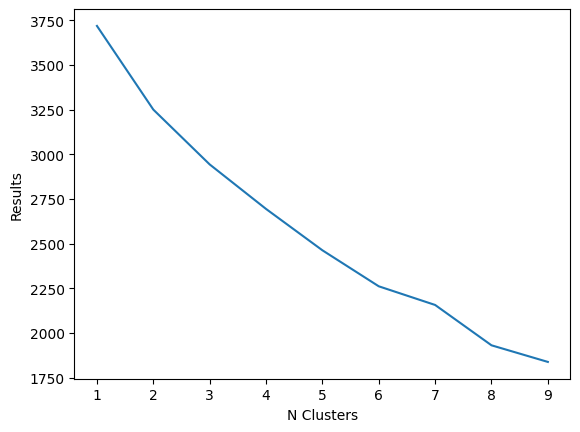

In [430]:
from sklearn.cluster import KMeans
results = []
i = 1
for n_clusters in range(1, 10):
    model_kmeans = KMeans(n_clusters, random_state=0)
    model_kmeans.fit(pd.DataFrame(pokemon_data_dict.values()))
    results.append(model_kmeans.inertia_)
    print("provant amb " ,i, " clusters")
    i += 1
plt.style.use("default") 
plt.plot(range(1, 10), results) 
plt.xticks(range(1, 10))
plt.ylabel("Results")
plt.xlabel("N Clusters")
plt.show()

Com podem veure Hem trobat el "Elbow" per a n = 6, ja que es en aquest punt on la pendent comença a no disminuir tant rapidament com ho feia abans

In [432]:
kmeans_n6 = KMeans(n_clusters=6,random_state=0)
kmeans_n6.fit(pd.DataFrame(pokemon_data_dict.values()))
print(kmeans_n6.labels_)


[2 2 2 4 4 0 4 4 4 0 0 0 4 4 3 1 5 1 5 4 4 4 0 4 0 4 4 2 2 2 1 5 1 5 4 4 5
 4 4 4 4 4 4 4 4 4 3 3 3 4 4 4 4 4 4 3 4 3 3 3 3 3 5 5 0 4 4 4 3 3 3 1 4 4
 2 2 2 1 1 3 4 4 4 4 4 4 1 1 4 2 4 4 4 4 4 4 3 3 3 0 0 4 4 0 4 4 4 4 4 4 4
 4 3 3 0 0 4 4 4 4 4 4 0 0 0 2 4 4 1 4 1 1 3 4 3 3 4 5 4 5 0 2 4 1 1 1 3 4
 4 0 0 0 4 4 4 4 4 4 1 1 1 2 4 4 4 4 2 2 2 2 2 2 0 0 3 3 3 2 0 3 4 4 4 4 3
 5 4 4 2 4 4 4 4 4 1 1 1 1 1 1 1 4 4 1 1 4 4 3 3 3 0 0 5 4 4 4 2 2 0 0 2 2
 4 1 0 0 4 4 4 4 5 5 1 3 4 4 4 5 1 1 0 4 4 4 0 2 2 4 5 4 1 2 0 2 0 1 4 3 3
 3 3 5 4 5 0 2 4 4 4 4 4 3 3 0 0 0 1 1 1 0 0 1 5 4 4 4 4 1 1 4 4 0 0 0 2 2
 2 2 4 1 1 1 4 0 4 0 3 0 2 0 0 4 4 0 3 1 3 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0
 0 5 2 2 3 3 0 0 5 5 5 5 5 3 3 3 3 3 4 4 4 0 0 0 0 1 5 4 4 4 1 1 5 5 4 0 0
 0 0 4 5 4 4 4 0 0 5 1 2 4 4 4 4 4 1 0 0 0 4 4 3 3 3 3 3 4 4 4 4 2 2 1 1 4
 4 4 4 4 4 4 0 4 4 4 4 5 3 3 3 3 0 0 0 0 2 2 3 4 4 4 4 4 4 0 0 0 0 0 1 1 4
 4 4 1 1 0 0 2 2 2 2 5 5 4 4 2 2 2 4 4 4 0 0 1 1 4 4 4 4 5 3 4 3 4 4 4 3 3
 5 3 3 5 3 4 5 5 2 2 2 4 

In [433]:
nClusters = 6
pokemons_cluster = []
for j in pd.DataFrame(pokemon_data_dict.values()):
    cluster = []
    for i in range(0, nClusters):
        p = pd.DataFrame(pokemon_data_dict.values())
        cluster.append(p[kmeans_n6.labels_ == i][j].mean())
    pokemons_cluster.append(cluster)

In [434]:
for i in range (0, nClusters):
    print("Al Cluster #", i, " hi han ", len(pd.DataFrame(pokemon_data_dict.values())[kmeans_n6.labels_ == i]), "Pokémons")

Al Cluster # 0  hi han  91 Pokémons
Al Cluster # 1  hi han  62 Pokémons
Al Cluster # 2  hi han  58 Pokémons
Al Cluster # 3  hi han  83 Pokémons
Al Cluster # 4  hi han  234 Pokémons
Al Cluster # 5  hi han  48 Pokémons


In [435]:
for j in range(0, 6):
    print("=================================================================================")
    print("POKEMONS EN EL CLUSTER NUMERO ", j)
    print("=================================================================================\n")
    for index in pd.DataFrame(pokemon_data_dict.values())[kmeans_n6.labels_ == j].index.values.astype(int):
        print(pokemon_data[index][0])    
    print("\n")

POKEMONS EN EL CLUSTER NUMERO  0

Charizard
Caterpie
Metapod
Butterfree
Vulpix Alola Form
Ninetales Alola Form
Farfetch'd
Scyther
Pinsir
Gyarados
Hoothoot
Noctowl
Togetic
Natu
Xatu
Shuckle
Delibird
Mantine
Skarmory
Wingull
Pelipper
Ninjask
Snorunt
Glalie
Combee
Vespiquen
Drifloon
Drifblim
Skorupi
Mantyke
Togekiss
Glaceon
Rotom Fan Rotom
Pidove
Tranquill
Unfezant
Woobat
Swoobat
Venipede
Whirlipede
Scolipede
Darumaka Galarian Form
Darmanitan Galarian Form
Darmanitan Galarian Zen
Dwebble
Crustle
Sigilyph
Vanillite
Vanillish
Vanilluxe
Emolga
Karrablast
Joltik
Galvantula
Cubchoo
Beartic
Shelmet
Accelgor
Rufflet
Braviary
Vullaby
Mandibuzz
Larvesta
Volcarona
Fletchling
Fletchinder
Talonflame
Hawlucha
Bergmite
Avalugg
Noibat
Noivern
Grubbin
Charjabug
Vikavolt
Cutiefly
Ribombee
Dewpider
Araquanid
Wimpod
Golisopod
Rookidee
Corvisquire
Corviknight
Blipbug
Cramorant
Sizzlipede
Centiskorch
Snom
Frosmoth
Eiscue


POKEMONS EN EL CLUSTER NUMERO  1

Sandshrew
Sandslash
Diglett
Dugtrio
Onix
Cubone
Marow

# Conclusió 

**A continuació mostrem un generador que selecciona pokemons al atzar, un per cada cluster, i forma un equip de 6 pokemons (maxim numero de pokemons que pot tenir un equip)**

Aquesta solució hauria de ser molt efectiva en cuant a atac, ja que disposem de pokemons molt diferents en cuant a habilitats (multipliers), lo qual ens dona un gran ventall a l'hora a lluitar contra altres pokemon.

In [450]:
#A continuacio el generador de equips
import random
for j in range(0, 6): 
    indexos = pd.DataFrame(pokemon_data_dict.values())[kmeans_n6.labels_ == j].index.values.astype(int)
    index = indexos[random.randint(0, len(indexos) - 1)]
    print(pokemon_data[index][0])    


Vulpix Alola Form
Terrakion
Amoonguss
Dottler
Carvanha
Duraludon


Conclusions: Tot i que amb aquest dataset no se m'ocurria res més per fer, hem solucionat un problema amb clustering que finalment sembla donar bons resultats. Aquesta es la llista amb els pokemons del teu equip ^^